In [6]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import pandas as pd
from   collections import Counter
import pickle
import seaborn as sns

In [7]:
read    = lambda f      : cv2.imread(f, cv2.IMREAD_GRAYSCALE)
norm    = lambda I      : cv2.normalize(I, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
dct     = lambda I      : cv2.dct(I.astype(np.float32))
idct    = lambda I      : cv2.idct(I.astype(np.float32))
first   = lambda x      : int(str("{:.2e}".format(x))[0]) if x > 0 else 0
firsts  = lambda A      : [first(a) for a in A]
hist    = lambda I      : np.histogram(firsts(I.ravel()), bins=range(11))[0][1:]
pdf     = lambda h      : h/np.sum(h) if np.sum(h) > 0 else h
ben     = lambda        : np.log10(1 + 1/np.arange(1, 10))
diffs   = lambda P      : [x-y for x, y in zip(P, ben())]
sigma   = lambda P      : np.sqrt(np.sum([d**2 for d in diffs(P)]))
cod     = lambda P      : sigma(P)/np.mean(P)
mean    = lambda I      : np.mean(I.ravel())
median  = lambda I      : np.median(I.ravel())
diffs2  = lambda P      : [pow(x-y,2) for x, y in zip(P, ben())]
bscore  = lambda I      : 1/(1 + np.sum(diffs2(pdf(hist(dct(I))))))
xspace  = lambda x,y,r  : np.logspace(x,y,num=r, base=2, dtype=np.int32)
xspace2 = np.linspace(2,1024, num=512, dtype=np.int16)

In [8]:
def stats(images):
    data = []
    for im, I in enumerate(images):
        for i in xspace2:
            scale = i/I.shape[1]
            h,w   = int(I.shape[0] * scale), int(I.shape[1] * scale)

            if h%2==1: h+=1
            if w%2==1: w+=1

            I2 = cv2.resize(I, (w,h), interpolation=cv2.INTER_AREA)
            c  = cod(pdf(hist(dct(I2))))
            data.append(
                {'image': im, 'scale': w, 'coeff': c, 'median': median(I2), "mean": mean(I2), "bscore": bscore(I2), "xcat": int(np.log2(w))}
            )
    return pd.DataFrame(data)

In [5]:
# Load all images in the data folder
images = [norm(read('data/' + f)) for f in os.listdir('data') if f.endswith('.jpeg') or f.endswith('.jpg')]

# Compute the stats for all images
df = stats(images[:5])

In [ ]:
# Save the stats to pickle file
with open('df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [9]:
# Load the stats from pickle file
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

In [47]:
scatter_kws = {"s": 10, "alpha": 0.8, "color": "grey"}
line_kws = {'linestyle':'--', 'linewidth':1, 'color':'orange'}

KeyboardInterrupt: 

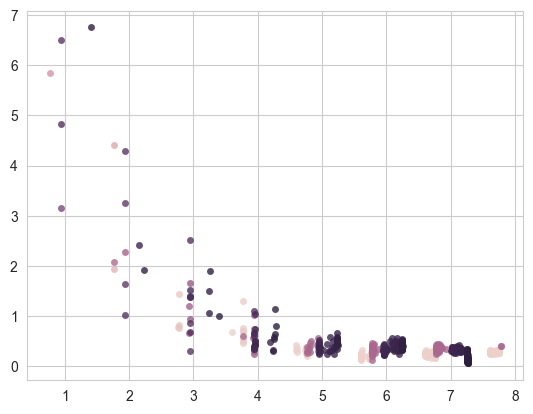

In [90]:
# Make a scatterplot with scale and coeff as x and y
ax = sns.stripplot(x="xcat", y="coeff", data=df, legend=False, alpha=0.8, hue="median", dodge=True)

# set y to log
ax.set(yscale="log")

# Set plot size 
ax.figure.set_size_inches(6,4)


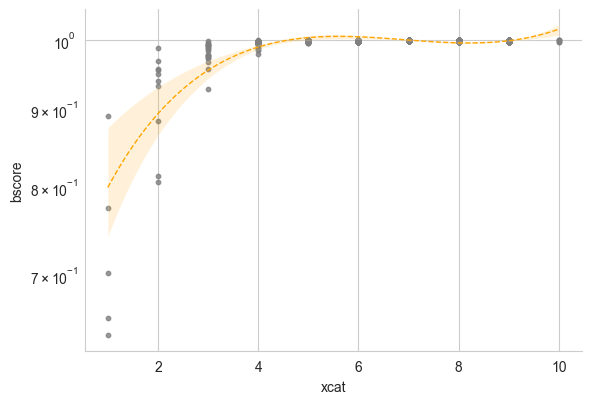

In [13]:
# Make a scatterplot with scale and bscore as x and y

ax = sns.lmplot(x="xcat", y="bscore", data=df, legend=False, scatter_kws=scatter_kws, line_kws=line_kws, order=3, ci=95)

# Set y to log
ax.set(yscale="log")

# Set plot size 
ax.figure.set_size_inches(6,4)